In [102]:
# Steven Mellor

import requests
import json
import os
from datetime import datetime, timedelta
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
%matplotlib inline

In [2]:
load_dotenv()

True

In [3]:
crypcomp_api_key = os.getenv('CRYPTOCOMPARE_API_KEY')

In [4]:
api_req = "https://min-api.cryptocompare.com/data/v2/histoday?fsym="

In [103]:
'''
    Building dataframe for Bitcoin
'''

btc_req = requests.get(api_req+'BTC&tsym=USD&limit=2000')
btc_historical_val = pd.DataFrame(json.loads(btc_req.content)['Data']['Data']).drop(columns={'conversionType','conversionSymbol'})
btc_historical_val = btc_historical_val[(btc_historical_val != 0).all(1)]
btc_historical_val['ohlc_avg'] = (btc_historical_val['high'] + btc_historical_val['low'] + btc_historical_val['open'] + btc_historical_val['close'])/4
btc_historical_val['oc_avg'] = (btc_historical_val['close'] - btc_historical_val['open'])/btc_historical_val['open']
btc_historical_val['volatility'] = (btc_historical_val['high'] - btc_historical_val['low']) / btc_historical_val['open']
btc_historical_val = btc_historical_val.set_index('time')
btc_historical_val.index = pd.to_datetime(btc_historical_val.index, unit='s')
current_btc_price = btc_historical_val.iloc[-1]['close']
btc_historical_val

,high,low,open,volumefrom,volumeto,close,ohlc_avg,oc_avg,volatility
time,,,,,,,,,
2015-07-31,288.69,280.77,287.02,49212.01,1.401907e+07,283.73,285.0525,-0.011463,0.027594
2015-08-01,284.53,276.30,283.73,39426.68,1.106883e+07,280.47,281.2575,-0.011490,0.029006
2015-08-02,282.50,275.93,280.47,35672.07,9.978638e+06,281.36,280.0650,0.003173,0.023425
2015-08-03,285.00,278.94,281.36,45894.10,1.300625e+07,281.58,281.7200,0.000782,0.021538
2015-08-04,285.66,279.58,281.58,44841.21,1.273220e+07,284.30,282.7800,0.009660,0.021592
...,...,...,...,...,...,...,...,...,...
2021-01-16,37942.44,35395.88,36790.17,54226.28,1.995054e+09,36025.26,36538.4375,-0.020791,0.069218
2021-01-17,36860.67,33854.83,36025.26,50913.30,1.806688e+09,35839.51,35645.0675,-0.005156,0.083437
2021-01-18,37429.24,34784.40,35839.51,43063.97,1.554687e+09,36623.04,36169.0475,0.021862,0.073797


In [104]:
'''
    Building dataframe for Ethereum
'''

eth_req = requests.get(api_req+'eth&tsym=USD&limit=2000')
eth_historical_val = pd.DataFrame(json.loads(eth_req.content)['Data']['Data']).drop(columns={'conversionType','conversionSymbol'})
eth_historical_val = eth_historical_val[(eth_historical_val != 0).all(1)]
eth_historical_val['ohlc_avg'] = (eth_historical_val['high'] + eth_historical_val['low'] + eth_historical_val['open'] + eth_historical_val['close'])/4
eth_historical_val['oc_avg'] = (eth_historical_val['close'] - eth_historical_val['open'])/eth_historical_val['open']
eth_historical_val['volatility'] = (eth_historical_val['high'] - eth_historical_val['low']) / eth_historical_val['open']
eth_historical_val = eth_historical_val.set_index('time')
eth_historical_val.index = pd.to_datetime(eth_historical_val.index, unit='s')
current_eth_price = eth_historical_val.iloc[-1]['close']
eth_historical_val

,high,low,open,volumefrom,volumeto,close,ohlc_avg,oc_avg,volatility
time,,,,,,,,,
2015-08-07,27.7900,0.7809,0.7812,53584.56,1.486083e+05,2.7730,8.031275,2.549667,34.573861
2015-08-08,2.5810,0.5958,2.7730,722558.00,5.835435e+05,0.8076,1.689350,-0.708763,0.715903
2015-08-09,0.9581,0.6043,0.8076,737119.57,5.475280e+05,0.7428,0.778200,-0.080238,0.438088
2015-08-10,0.7628,0.5990,0.7428,585917.04,4.011071e+05,0.6846,0.697300,-0.078352,0.220517
2015-08-11,1.1650,0.6548,0.6846,1479695.62,1.567649e+06,1.0590,0.890850,0.546889,0.745253
...,...,...,...,...,...,...,...,...,...
2021-01-16,1293.2000,1152.9200,1169.0600,1020332.59,1.250939e+09,1228.5200,1210.925000,0.050861,0.119994
2021-01-17,1269.4900,1166.6000,1228.5200,783042.23,9.576329e+08,1233.7300,1224.585000,0.004241,0.083751
2021-01-18,1260.6800,1183.7800,1233.7300,663535.05,8.134096e+08,1258.3100,1234.125000,0.019923,0.062331


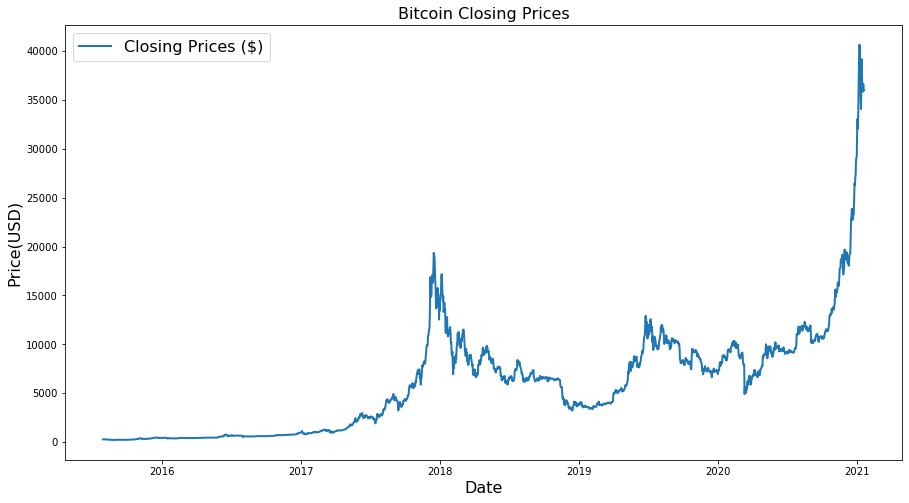

In [105]:
#Bitcoin closing prices
fig, ax = plt.subplots(1, figsize=(15,8))
ax.plot(btc_historical_val['close'], label='Closing Prices ($)', linewidth=2)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Price(USD)', fontsize=16)
ax.set_title('Bitcoin Closing Prices', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

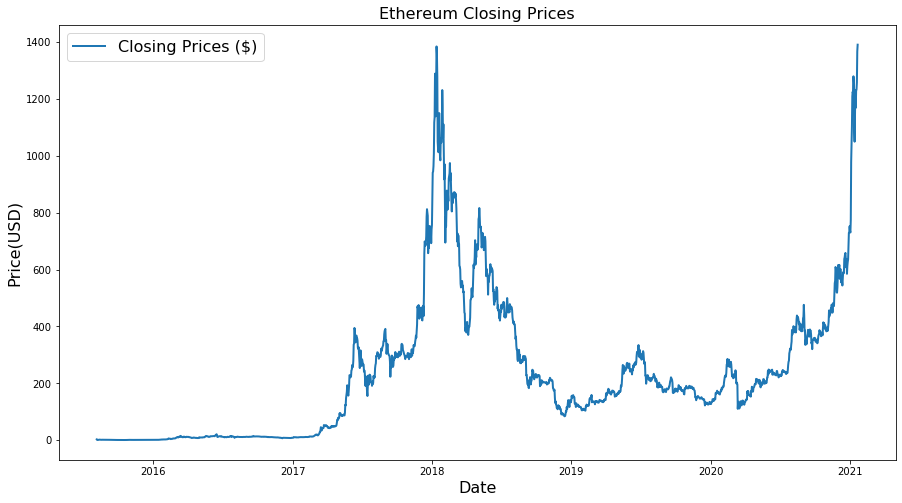

In [106]:
#Ethereum closing prices
fig, ax = plt.subplots(1, figsize=(15,8))
ax.plot(eth_historical_val['close'], label='Closing Prices ($)', linewidth=2)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Price(USD)', fontsize=16)
ax.set_title('Ethereum Closing Prices', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

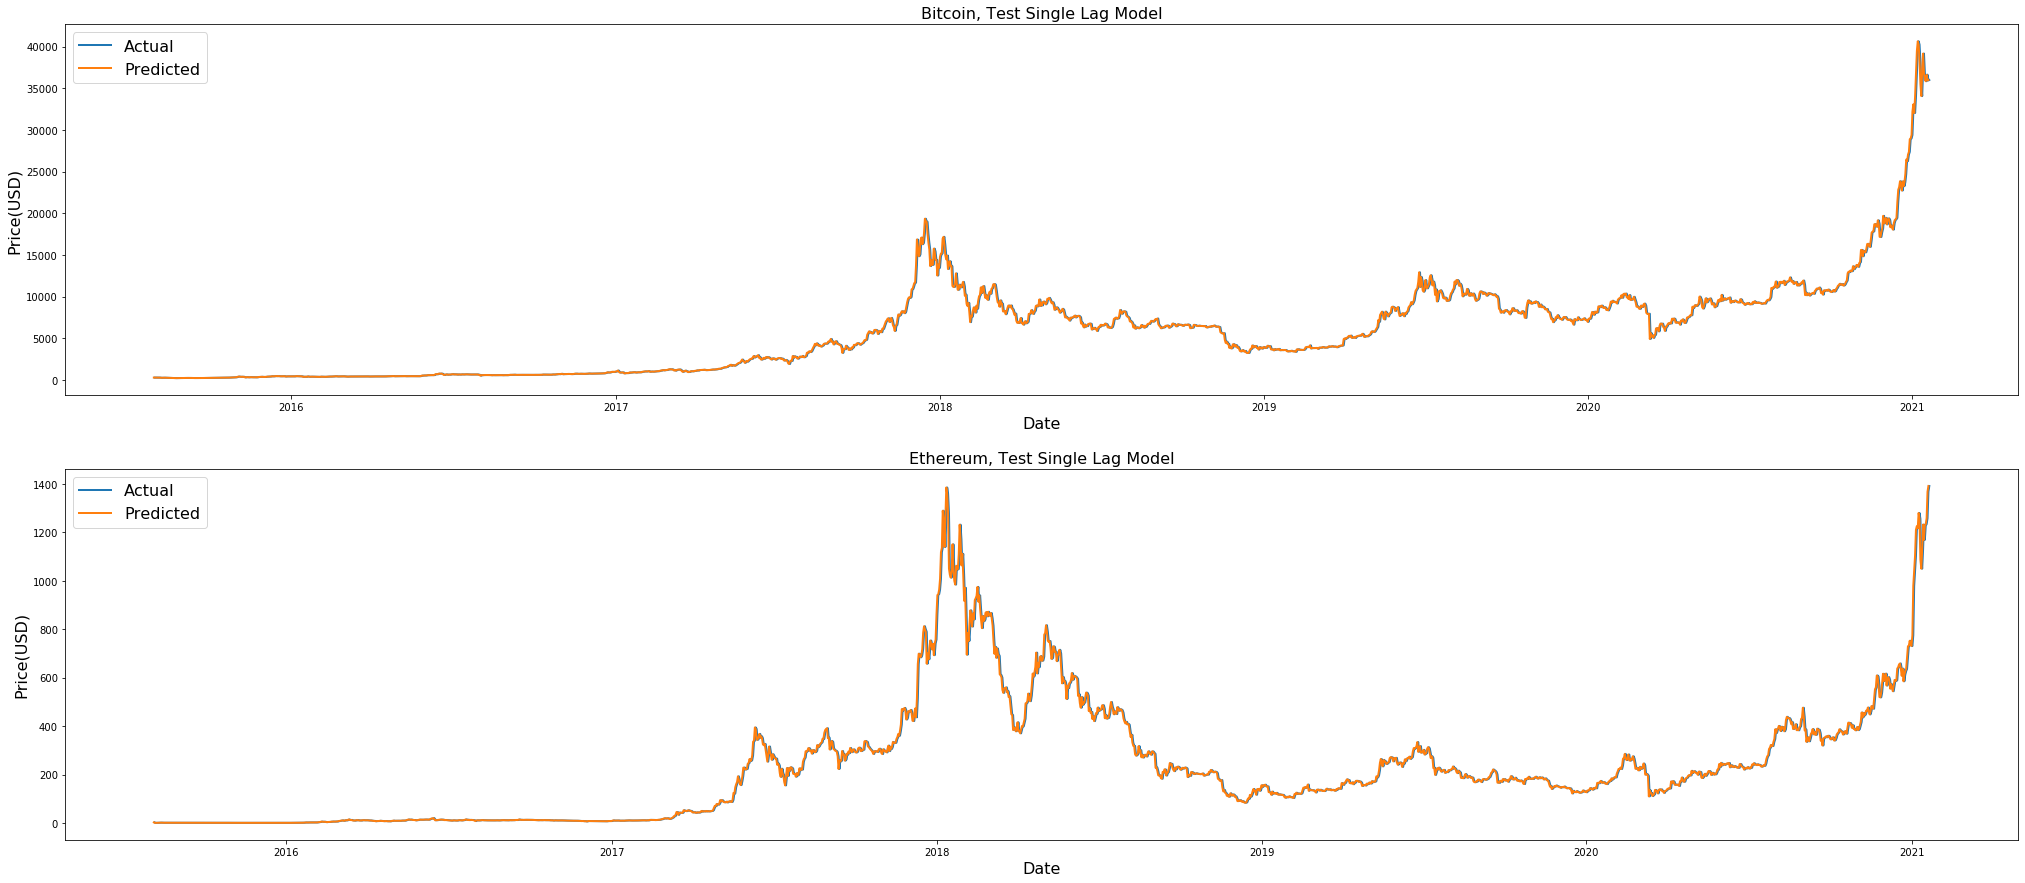

In [107]:
btc_single_day_lag = btc_historical_val.set_index(pd.DatetimeIndex(btc_historical_val.index) - pd.DateOffset(1))
eth_single_day_lag = eth_historical_val.set_index(pd.DatetimeIndex(eth_historical_val.index) - pd.DateOffset(1))
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(35,15))
ax1.plot(btc_historical_val['close'], label='Actual', linewidth=2)
ax2.plot(eth_historical_val['close'], label='Actual', linewidth=2)
ax1.plot(btc_single_day_lag['close'], label='Predicted', linewidth=2)
ax2.plot(eth_single_day_lag['close'], label='Predicted', linewidth=2)
ax1.set_xlabel('Date', fontsize=16)
ax2.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Price(USD)', fontsize=16)
ax2.set_ylabel('Price(USD)', fontsize=16)
ax1.set_title('Bitcoin, Test Single Lag Model', fontsize=16)
ax2.set_title('Ethereum, Test Single Lag Model', fontsize=16)
ax1.legend(loc='best', fontsize=16)
ax2.legend(loc='best', fontsize=16)
plt.show()

In [108]:
'''
    Bitcoin: Shifting to a 15 window, splitting my train and test periods by a new column 'shifted dates' 
    to later append, then instantuating the StandardScaler function
'''
btc_market = btc_historical_val.copy()
btc_market['shifted_date']=btc_market['close'].shift(-15)
btc_market.tail()
btc_market.dropna(inplace=True)
btc_X = btc_market.drop('shifted_date',axis=1)
btc_scaler = StandardScaler()
btc_X = btc_scaler.fit_transform(btc_X)
btc_y = btc_market['shifted_date']

In [109]:
'''
    Ethereum: Shifting to a 15 window, splitting my train and test periods by a new column 'shifted dates' 
    to later append, then instantuating the StandardScaler function
'''
eth_market = eth_historical_val.copy()
eth_market['shifted_date']=eth_market['close'].shift(-15)
eth_market.tail()
eth_market.dropna(inplace=True)
eth_X = eth_market.drop('shifted_date',axis=1)
eth_scaler = StandardScaler()
eth_X = eth_scaler.fit_transform(eth_X)
eth_y = eth_market['shifted_date']

In [110]:
'''
    Bitcon: Creating a [x,y] train/test split
'''
btc_X_train,btc_X_test,btc_y_train,btc_y_test = train_test_split(btc_X,btc_y,test_size=0.3,random_state=101)

In [111]:
'''
    Ethereum: Creating a [x,y] train/test split
'''
eth_X_train,eth_X_test,eth_y_train,eth_y_test = train_test_split(eth_X,eth_y,test_size=0.3,random_state=101)

In [112]:
'''
   Bitcoin: Calculating regression accuracy using RandomForestRegressor,
   which allows me also deal with rather large data sets and utilize multiple decision trees.
'''
btc_regressor = RandomForestRegressor(n_estimators = 200,random_state = 101)
btc_regressor.fit(btc_X_train,btc_y_train)
btc_generate_accuracy = btc_regressor.score(btc_X_test,btc_y_test)
btc_generate_accuracy = btc_generate_accuracy*100
btc_generate_accuracy = float("{0:.4f}".format(btc_generate_accuracy))
print('Bitcoin 15 day regression accuracy % on is:',btc_generate_accuracy,'%')

Bitcoin 15 day regression accuracy % on is: 95.0658 %


In [113]:
'''
   Ethereum: Calculating regression accuracy using RandomForestRegressor,
   which allows me also deal with rather large data sets and utilize multiple decision trees.
'''
eth_regressor = RandomForestRegressor(n_estimators = 200,random_state = 101)
eth_regressor.fit(eth_X_train,eth_y_train)
eth_generate_accuracy = eth_regressor.score(eth_X_test,eth_y_test)
eth_generate_accuracy = eth_generate_accuracy*100
eth_generate_accuracy = float("{0:.4f}".format(eth_generate_accuracy))
print('Bitcoin 15 day regression accuracy % on is:',eth_generate_accuracy,'%')

Bitcoin 15 day regression accuracy % on is: 91.5005 %


In [114]:
'''
    Bitcoin: Creating the forecasted new column and retrieving the price projected in that 15 day window
'''
btc_forecast = btc_regressor.predict(btc_X[-15:])
btc_current_date = btc_market.iloc[-1].name
btc_mod_date = btc_current_date + timedelta(days=1)
btc_new_date = pd.date_range(btc_mod_date,periods=15,freq='D')
btc_forecast_frame = pd.DataFrame(btc_forecast,columns=['forecast'],index=btc_new_date)
btc_market = btc_market.append(btc_forecast_frame)
btc_market_forecast = btc_market[['forecast']]
btc_forecasted_price = float("{0:.2f}".format(btc_market_forecast.iloc[-1].forecast))

In [115]:
'''
    Ethereum: Creating the forecasted new column and retrieving the price projected in that 15 day window
'''
eth_forecast = eth_regressor.predict(eth_X[-15:])
eth_current_date = eth_market.iloc[-1].name
eth_mod_date = eth_current_date + timedelta(days=1)
eth_new_date = pd.date_range(eth_mod_date,periods=15,freq='D')
eth_forecast_frame = pd.DataFrame(eth_forecast,columns=['forecast'],index=eth_new_date)
eth_market = eth_market.append(eth_forecast_frame)
eth_market_forecast = eth_market[['forecast']]
eth_forecasted_price = float("{0:.2f}".format(eth_market_forecast.iloc[-1].forecast))

In [116]:
print('Current Bitcoin price is:', current_btc_price, 'and project price in 15 days is:',btc_forecasted_price)

Current Bitcoin price is: 35987.74 and project price in 15 days is: 36312.73


In [117]:
print('Current Ethereum price is:', current_eth_price, 'and project price in 15 days is:',eth_forecasted_price)

Current Ethereum price is: 1391.24 and project price in 15 days is: 1247.77


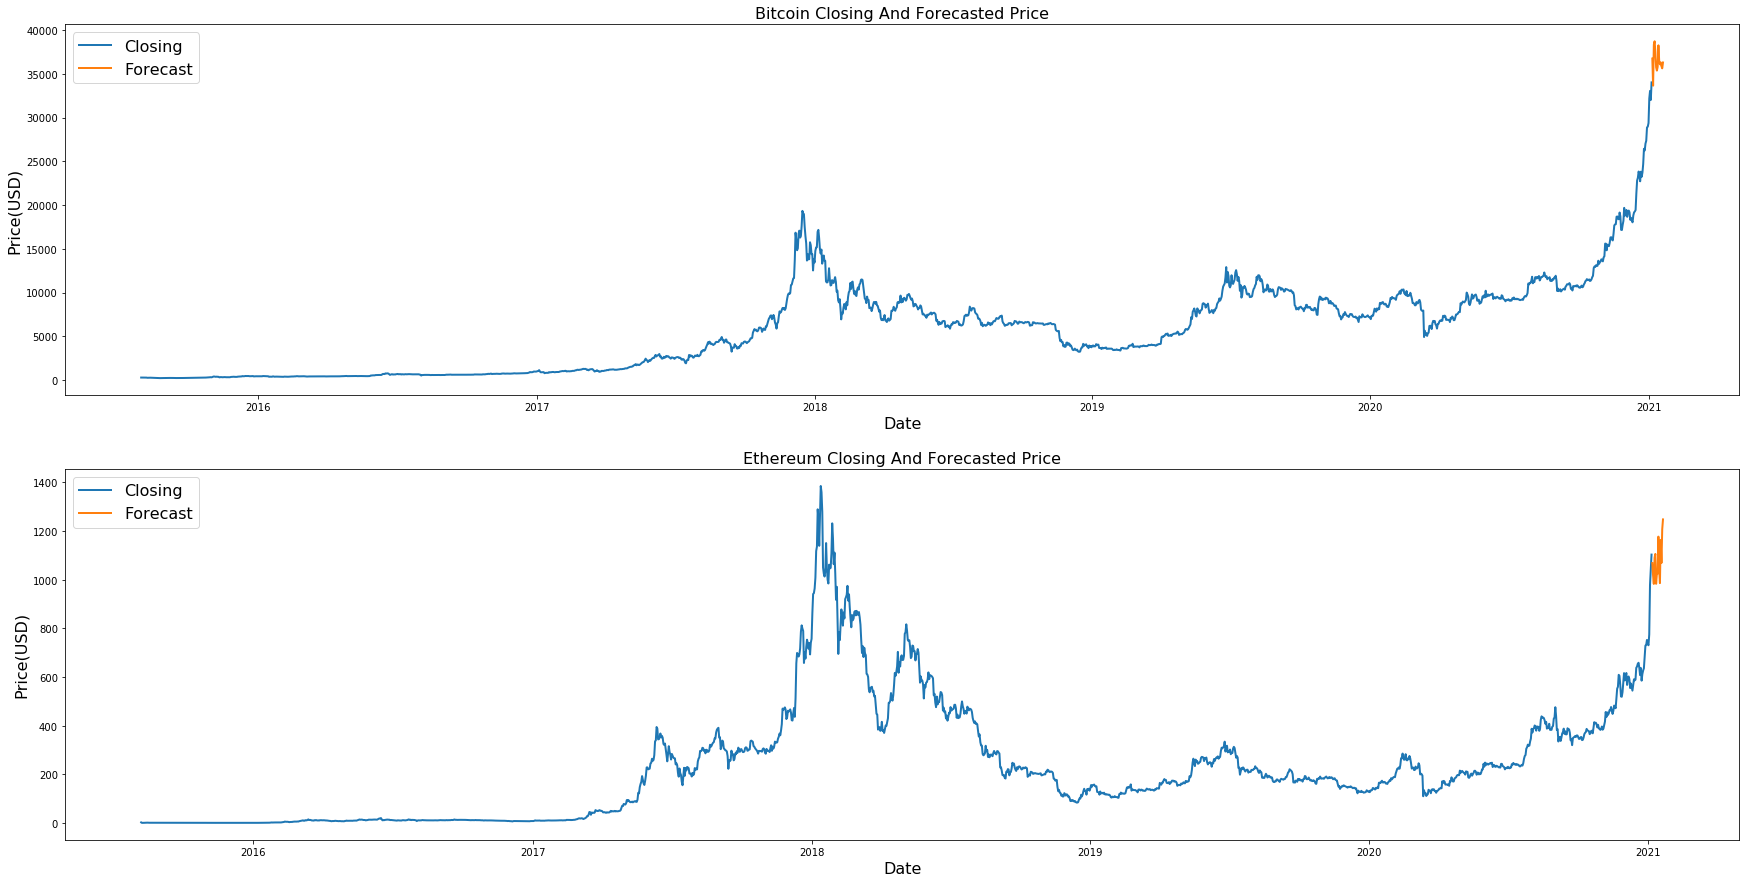

In [134]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(30,15))
ax1.plot(btc_market['close'], label='Closing', linewidth=2)
ax2.plot(eth_market['close'], label='Closing', linewidth=2)
ax1.plot(btc_market['forecast'], label='Forecast', linewidth=2)
ax2.plot(eth_market['forecast'], label='Forecast', linewidth=2)
ax1.set_xlabel('Date', fontsize=16)
ax2.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Price(USD)', fontsize=16)
ax2.set_ylabel('Price(USD)', fontsize=16)
ax1.set_title('Bitcoin Closing And Forecasted Price', fontsize=16)
ax2.set_title('Ethereum Closing And Forecasted Price', fontsize=16)
ax1.legend(loc='best', fontsize=16)
ax2.legend(loc='best', fontsize=16)

In [119]:
'''
    LSTM Training
'''


#Function to split data into training/test sets with a 20% weight
def train_test(df, test_size):
    split = len(df) - int(test_size * len(df))
    train = df.iloc[:split]
    test = df.iloc[split:]
    return train, test


btc_train, btc_test = train_test(btc_historical_val, test_size=0.2)
eth_train, eth_test = train_test(eth_historical_val, test_size=0.2)


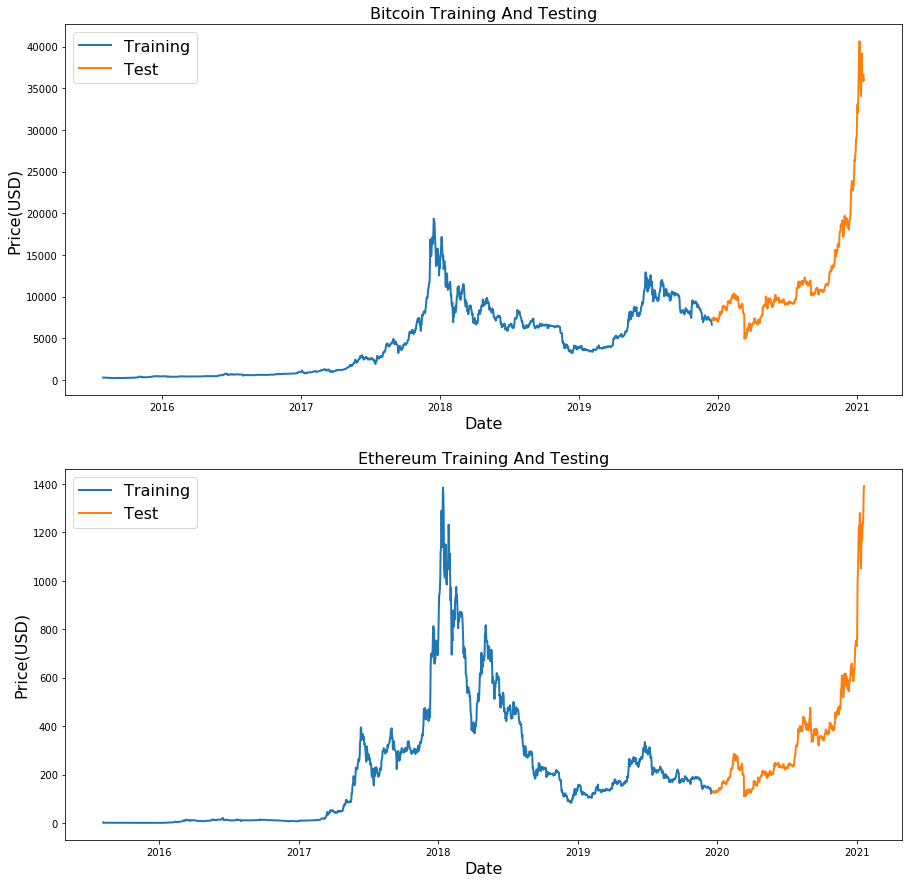

In [120]:
#Plot training/test split of btc/eth
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,15))
ax1.plot(btc_train['close'], label='Training', linewidth=2)
ax2.plot(eth_train['close'], label='Training', linewidth=2)
ax1.plot(btc_test['close'], label='Test', linewidth=2)
ax2.plot(eth_test['close'], label='Test', linewidth=2)
ax1.set_xlabel('Date', fontsize=16)
ax2.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Price(USD)', fontsize=16)
ax2.set_ylabel('Price(USD)', fontsize=16)
ax1.set_title('Bitcoin Training And Testing', fontsize=16)
ax2.set_title('Ethereum Training And Testing', fontsize=16)
ax1.legend(loc='best', fontsize=16)
ax2.legend(loc='best', fontsize=16)

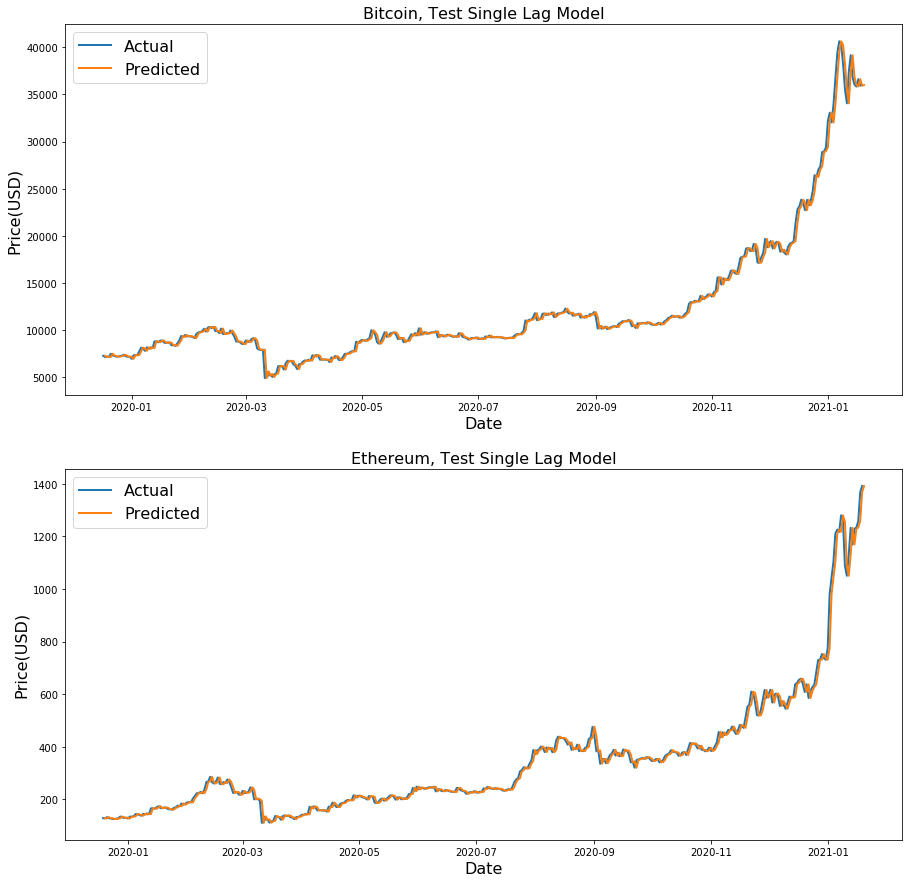

In [121]:
#Single lag model
btc_test_lag = btc_test.set_index(pd.DatetimeIndex(btc_test.index) - pd.DateOffset(1))
eth_test_lag = eth_test.set_index(pd.DatetimeIndex(eth_test.index) - pd.DateOffset(1))
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,15))
#pd.DatetimeIndex(btc_test.index) - pd.DateOffset(1)
ax1.plot(btc_test_lag['close'], label='Actual', linewidth=2)
ax2.plot(eth_test_lag['close'], label='Actual', linewidth=2)
ax1.plot(btc_test['close'], label='Predicted', linewidth=2)
ax2.plot(eth_test['close'], label='Predicted', linewidth=2)
ax1.set_xlabel('Date', fontsize=16)
ax2.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Price(USD)', fontsize=16)
ax2.set_ylabel('Price(USD)', fontsize=16)
ax1.set_title('Bitcoin, Test Single Lag Model', fontsize=16)
ax2.set_title('Ethereum, Test Single Lag Model', fontsize=16)
ax1.legend(loc='best', fontsize=16)
ax2.legend(loc='best', fontsize=16)
plt.show()

In [122]:

def normalise_zero(df):
    """ 
    Normalise dataframe column wise to scalar index 
    """
    return df / df.iloc[0] - 1

def window_sequence(df, window=10, zero_base=True):
    """ 
    Dataframe conversion to sequence of length of 'window'
    """
    window_data = []
    for idx in range(len(df) - window):
        tmp = df[idx: (idx + window)].copy()
        if zero_base:
            tmp = normalise_zero(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def data_preperation(df,target_col, window=10, zero_base=True, test_size=0.2):
    """ LSTM data prepreratiom """
    
    train_data, test_data = train_test_split(df, test_size=test_size)
    
    # extract window data
    X_train = window_sequence(train_data, window, zero_base)
    X_test = window_sequence(test_data, window, zero_base)
    
    # extract targets
    y_train = train_data[target_col][window:].values
    y_test = test_data[target_col][window:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window].values - 1
        y_test = y_test / test_data[target_col][:-window].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [123]:
def model_lstm_builder(input_data, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [124]:
btc_historical_orig = pd.DataFrame(json.loads(btc_req.content)['Data']['Data']).drop(columns={'conversionType','conversionSymbol'})
btc_historical_orig = btc_historical_orig.set_index('time')
btc_historical_orig.index = pd.to_datetime(btc_historical_orig.index, unit='s')
btc_historical_orig = btc_historical_orig[['close', 'high', 'low', 'open', 'volumefrom', 'volumeto']]

eth_historical_orig = pd.DataFrame(json.loads(eth_req.content)['Data']['Data']).drop(columns={'conversionType','conversionSymbol'})
eth_historical_orig = eth_historical_orig.set_index('time')
eth_historical_orig = eth_historical_orig[(eth_historical_orig != 0).all(1)]
eth_historical_orig.index = pd.to_datetime(eth_historical_orig.index, unit='s')
eth_historical_orig = eth_historical_orig[['close', 'high', 'low', 'open', 'volumefrom', 'volumeto']]

In [125]:
'''
    I chose to use MSLE as it was more forgiving on a larger dataset
'''
np.random.seed(45)

#params
window = 7
test_size = 0.1
zero_base = True
neurons = 20
epochs = 50
batch_size = 4
loss = 'mean_squared_logarithmic_error'
dropout = 0.25
optimizer = 'adam'
target_close='close'

In [126]:
bit_train, bit_test, bit_X_train, bit_X_test, bit_y_train, bit_y_test = data_preperation(
    btc_historical_orig, target_col=target_close, window=window, zero_base=zero_base, test_size=test_size)

In [127]:
btc_model = model_lstm_builder(bit_X_train, 
                             output_size=1, 
                             neurons=neurons, 
                             dropout=dropout, 
                             loss=loss,
                             optimizer=optimizer)
btc_fit = btc_model.fit(
    bit_X_train, bit_y_train, epochs=50, batch_size=4, verbose=1, shuffle=True)

Epoch 1/50
449/449 [==============================] - 2s 5ms/step - loss: 0.7649
Epoch 2/50
449/449 [==============================] - 2s 5ms/step - loss: 0.6326
Epoch 3/50
449/449 [==============================] - 2s 5ms/step - loss: 0.6244
Epoch 4/50
449/449 [==============================] - 2s 5ms/step - loss: 0.6164
Epoch 5/50
449/449 [==============================] - 2s 5ms/step - loss: 0.6114
Epoch 6/50
449/449 [==============================] - 2s 5ms/step - loss: 0.6049
Epoch 7/50
449/449 [==============================] - 2s 5ms/step - loss: 0.6003
Epoch 8/50
449/449 [==============================] - 2s 4ms/step - loss: 0.5876
Epoch 9/50
449/449 [==============================] - 2s 5ms/step - loss: 0.5858
Epoch 10/50
449/449 [==============================] - 2s 5ms/step - loss: 0.6008
Epoch 11/50
449/449 [==============================] - 2s 5ms/step - loss: 0.5741
Epoch 12/50
449/449 [==============================] - 3s 6ms/step - loss: 0.5906
Epoch 13/50
449/449 [====

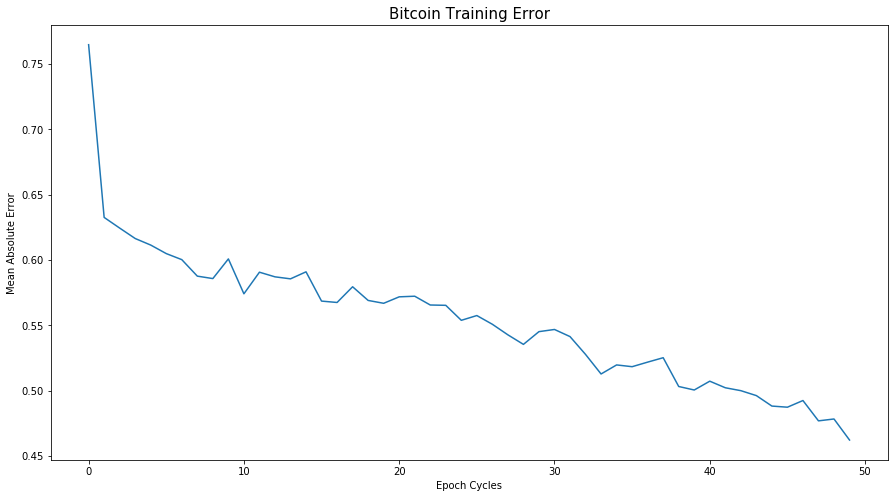

In [128]:
fig, ax = plt.subplots(1,figsize=(15,8))
ax.plot(btc_fit.epoch, btc_fit.history['loss'])
ax.set_ylabel("Mean Absolute Error", fontsize=10)
ax.set_xlabel("Epoch Cycles", fontsize=10)
ax.set_title("Bitcoin Training Error", fontsize=15)
plt.show()

In [129]:
eth_train, eth_test, eth_X_train, eth_X_test, eth_y_train, eth_y_test = data_preperation(
    eth_historical_orig, target_col=target_close, window=window, zero_base=zero_base, test_size=test_size)

In [130]:
eth_model = model_lstm_builder(eth_X_train, 
                             output_size=1, 
                             neurons=20, 
                             dropout=0.25, 
                             loss='mae',
                             optimizer='adam')
eth_fit = eth_model.fit(
    eth_X_train, eth_y_train, epochs=50, batch_size=4, verbose=1, shuffle=True)

Epoch 1/50
447/447 [==============================] - 2s 5ms/step - loss: 27.1285
Epoch 2/50
447/447 [==============================] - 2s 5ms/step - loss: 26.6806
Epoch 3/50
447/447 [==============================] - 2s 5ms/step - loss: 26.4605
Epoch 4/50
447/447 [==============================] - 2s 5ms/step - loss: 26.1951
Epoch 5/50
447/447 [==============================] - 2s 5ms/step - loss: 25.9822
Epoch 6/50
447/447 [==============================] - 2s 5ms/step - loss: 25.8195
Epoch 7/50
447/447 [==============================] - 2s 4ms/step - loss: 25.7084
Epoch 8/50
447/447 [==============================] - 2s 4ms/step - loss: 25.5774
Epoch 9/50
447/447 [==============================] - 2s 5ms/step - loss: 25.6662
Epoch 10/50
447/447 [==============================] - 2s 5ms/step - loss: 25.6294
Epoch 11/50
447/447 [==============================] - 2s 4ms/step - loss: 25.6840
Epoch 12/50
447/447 [==============================] - 2s 5ms/step - loss: 25.5845
Epoch 13/50
4

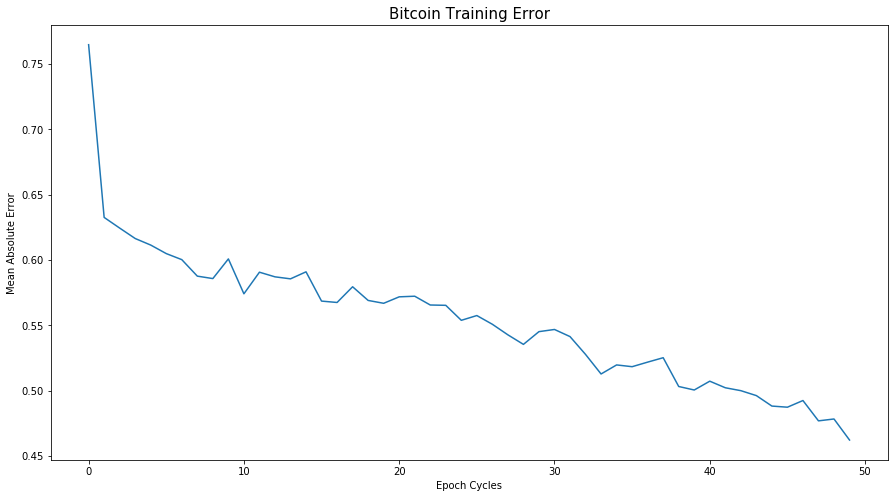

In [131]:
fig, ax = plt.subplots(1,figsize=(15,8))
ax.plot(eth_fit.epoch, btc_fit.history['loss'])
ax.set_ylabel("Mean Absolute Error", fontsize=10)
ax.set_xlabel("Epoch Cycles", fontsize=10)
ax.set_title("Bitcoin Training Error", fontsize=15)
plt.show()

### Resources: 
    1. https://min-api.cryptocompare.com/documentation
    2. https://medium.com/coinmonks/cryptocurrency-price-prediction-using-deep-learning-f738ead48ffd
    3. https://colah.github.io/posts/2015-08-Understanding-LSTMs/
    4. https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/
    5. https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/mean-squared-logarithmic-error-(msle)
    6. https://towardsdatascience.com/cryptocurrency-prediction-with-lstm-4cc369c43d1b
    7. https://towardsdatascience.com/stock-prediction-using-recurrent-neural-networks-c03637437578